# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

In [3]:
%matplotlib notebook

### Rozwiązanie

<IPython.core.display.Javascript object>


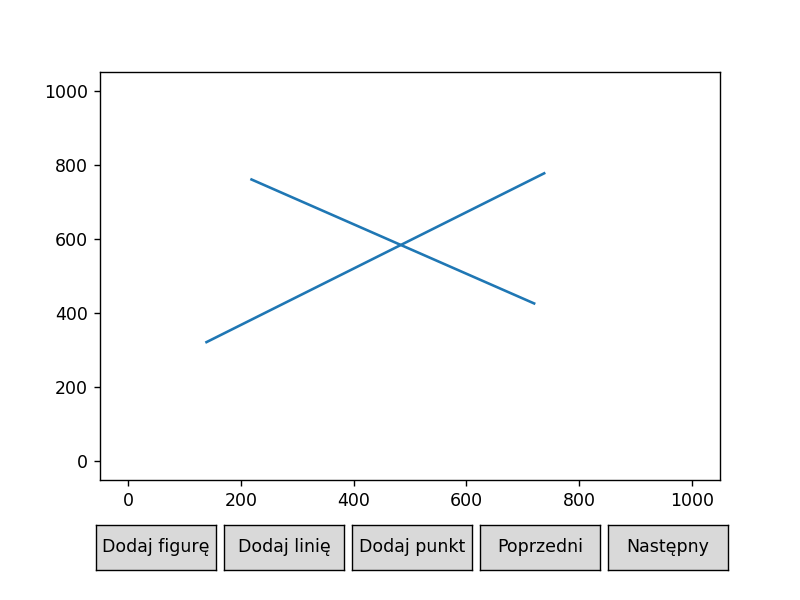

In [7]:
#Miejsce do narysowania odcinków:
plot = Plot(points = [PointsCollection([(0, 0), (1000, 1000)], color = 'white')])
plot.draw()

In [8]:
def plot_to_points(p):
    lines = p.scenes[0].lines[0].lines
    return [x[0] for x in lines] + [x[1] for x in lines]

In [9]:
def plot_to_lines(p):
    lines = p.scenes[0].lines[0].lines
    return lines

In [10]:
def remove_unacceptable_lines(p):
    lines = plot_to_lines(p)
    lines = [ elem for elem in lines if elem[0][0] != elem[1][0]]
    # biore linie i zmieniam je w tablicę punktów, gdzie każdy punkt ma zapisane do której linii należy
    # usuwam z tablicy jedną z linii których współrzędna xowa się powtarza
    sorted_points = []
    for i in range(len(lines)):
        sorted_points.append((lines[i][0], i))
        sorted_points.append((lines[i][1], i))
    sorted_points.sort()
    
    to_remove = []
    for i in range(len(sorted_points) - 1):
        if sorted_points[i][0] == sorted_points[i + 1][0]:
            to_remove.append(sorted_points[i][1])
    
    to_remove = list(dict.fromkeys(to_remove))
    to_remove.sort(reverse = True)
    
    for i in to_remove:
        lines.pop(i)
    
    p = Plot(lines = [LinesCollection(lines)])
    return p

In [11]:
# Zapis odcinków do pliku:

def plot_to_json(pl):
    pl = remove_unacceptable_lines(pl)
    with open('lines.json', 'w') as file:
        file.write(pl.toJson())

drawn_plot = Plot([plot.get_added_elements()])
plot_to_json(drawn_plot)

<IPython.core.display.Javascript object>


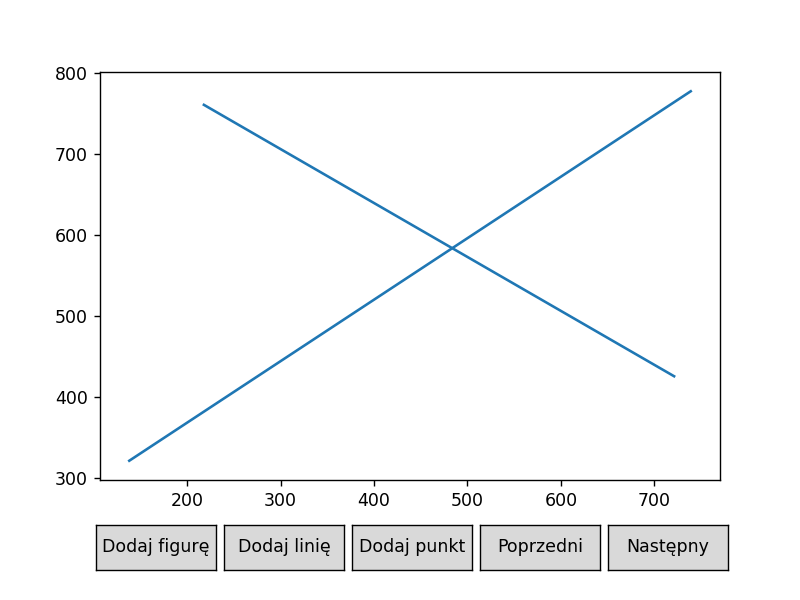

In [12]:
# Odczyt odcinków z pliku

with open('lines.json', 'r') as file:
    json = file.read()

lines = Plot(json = json)
lines.draw()

<IPython.core.display.Javascript object>


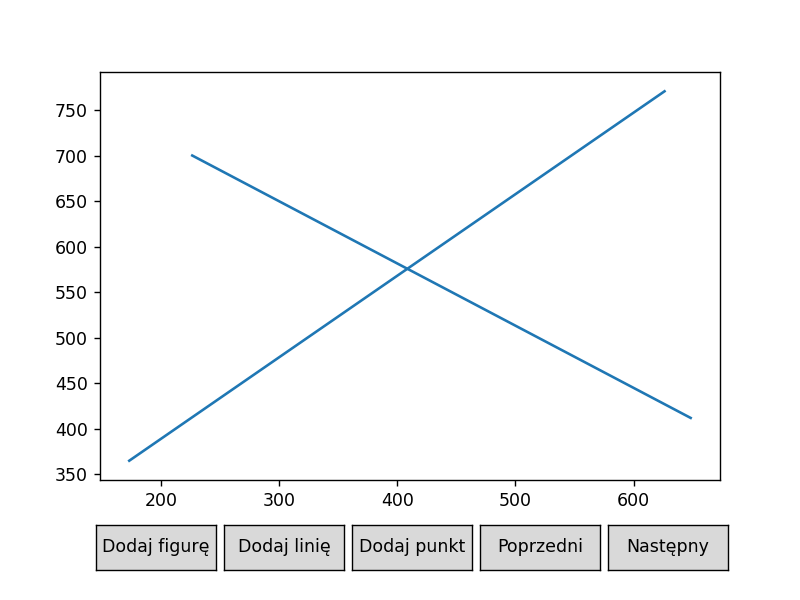

In [13]:
# Zbiór 1
with open('krzyz.json', 'r') as file:
    json = file.read()

cross = Plot(json = json)
cross.draw()

<IPython.core.display.Javascript object>


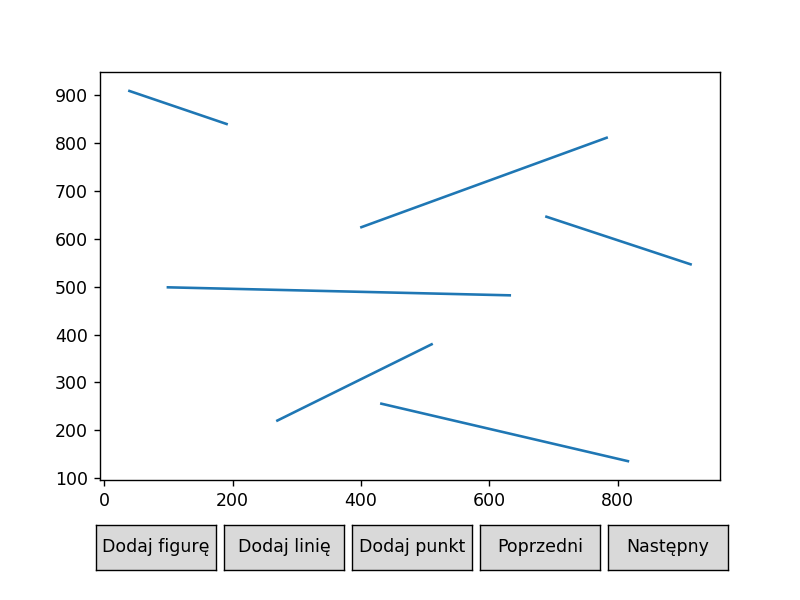

In [14]:
# Zbiór nieprzecinających się odcinków
with open('nonintersecting.json', 'r') as file:
    json = file.read()

nonintersecting = Plot(json = json)
nonintersecting.draw()

<IPython.core.display.Javascript object>


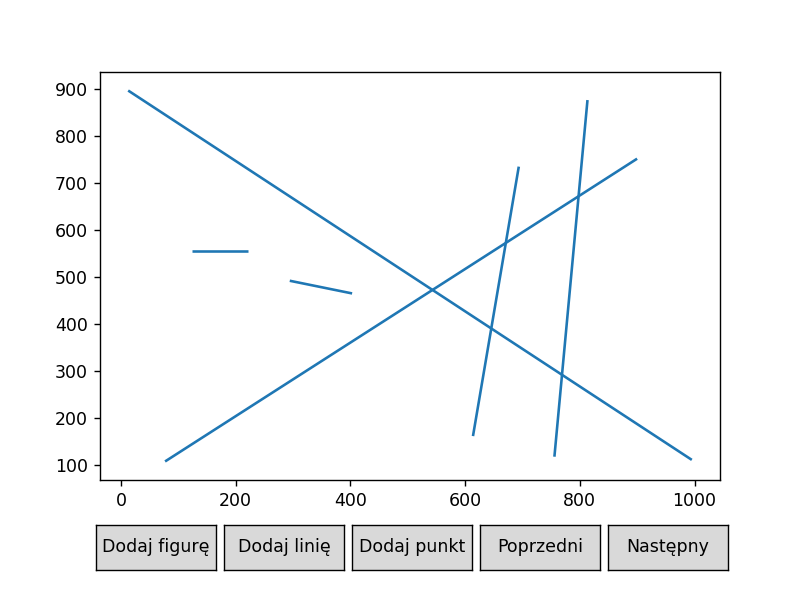

In [15]:
# Przyklad z cwiczen
with open('przyklad_z_cwiczen.json', 'r') as file:
    json = file.read()

example = Plot(json = json)
example.draw()

<IPython.core.display.Javascript object>


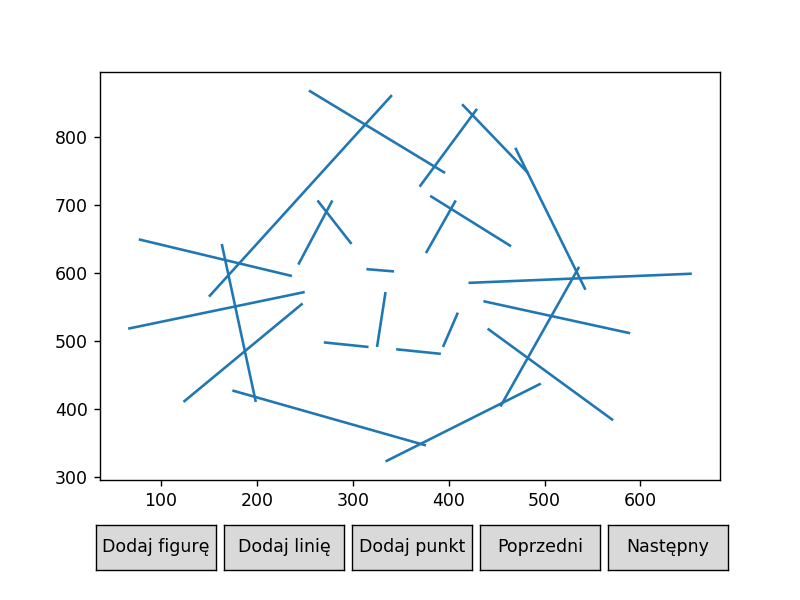

In [16]:
# Kotek
with open('cat.json', 'r') as file:
    json = file.read()



cat = Plot(json = json)
cat.draw()

<IPython.core.display.Javascript object>


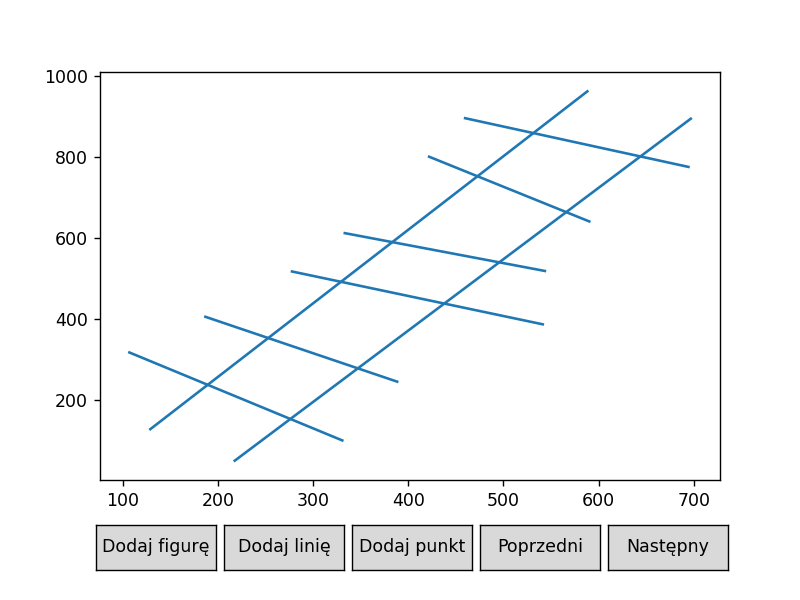

In [17]:
# Ladder

with open('ladder.json', 'r') as file:
    json = file.read()

ladder = Plot(json = json)
ladder.draw()

<IPython.core.display.Javascript object>


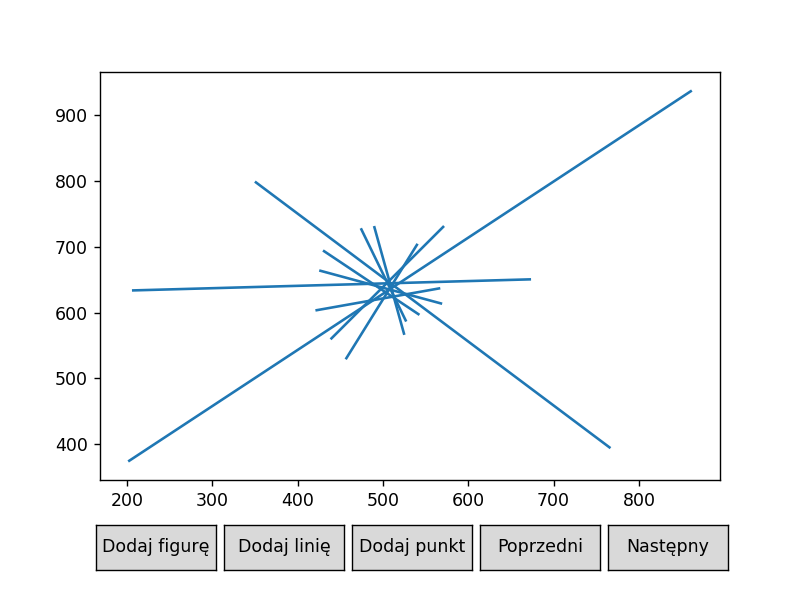

In [18]:
# Star

with open('star.json', 'r') as file:
    json = file.read()

star = Plot(json = json)
star.draw()

[[[10, 0], [500, 0]], [[300, 0], [700, 0]]]


<IPython.core.display.Javascript object>


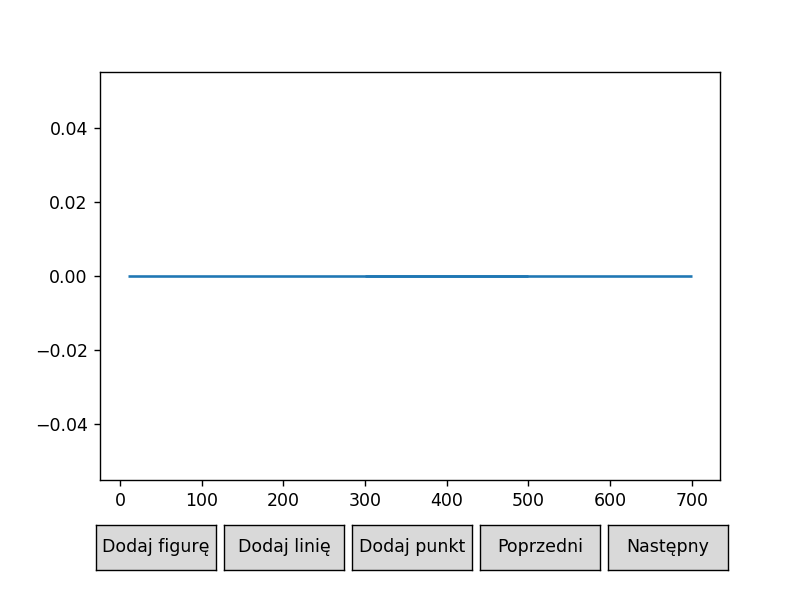

In [19]:
# Overlap
with open('overlap.json', 'r') as file:
    json = file.read()



overlap = Plot(json = json)
print(plot_to_lines(overlap))
overlap.draw()

<IPython.core.display.Javascript object>


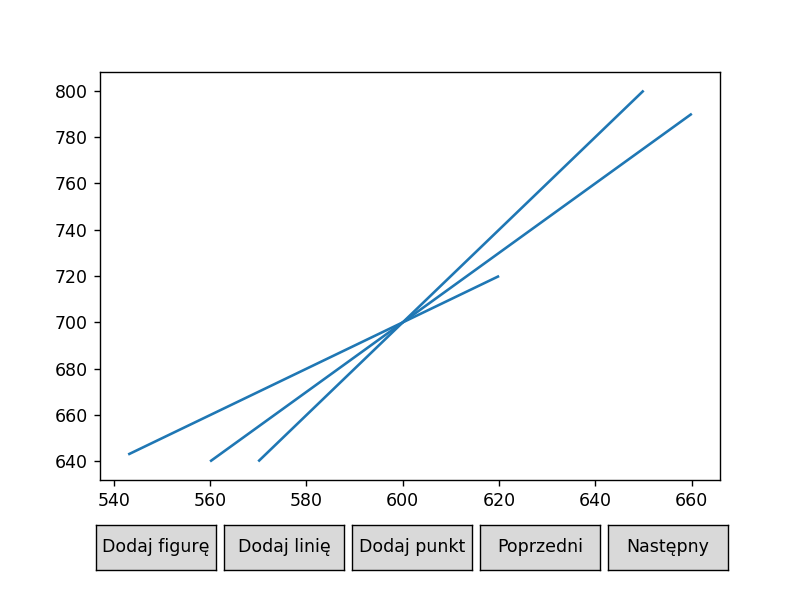

In [20]:
# Triple intersection

with open('triple_intersection.json', 'r') as file:
    json = file.read()

triple = Plot(json = json)
triple.draw()

In [21]:
# Zapis losowo zadanych odcinków do pliku
from random import uniform

lines = []
rang = 100
amount = 100
for i in range(amount):
    x1 = uniform(-rang, rang)
    y1 = uniform(-rang, rang)
    x2 = uniform(-rang, rang)
    y2 = uniform(-rang, rang)
    lines.append([(x1,y1),(x2,y2)])


rand_lines = Plot(lines = [LinesCollection(lines)])
rand_lines = remove_unacceptable_lines(rand_lines)
with open('random_lines.json', 'w') as file:
   file.write(rand_lines.toJson())

<IPython.core.display.Javascript object>


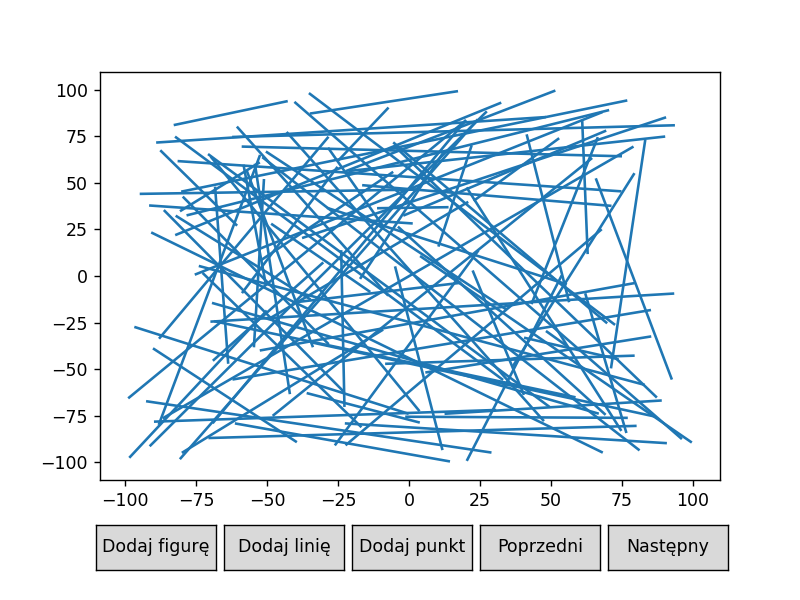

In [22]:
# Losowe odcinki

with open('random_lines.json', 'r') as file:
    json = file.read()

rand_lines = Plot(json = json)
rand_lines.draw()

In [23]:
class Broom:
    def __init__(self, x):
        self.x = x
        
    def update(self, x):
        self.x = x

In [24]:
class Point:
    def __init__(self, x, y, line1, line2, typ):
        self.x = x
        self.y = y
        self.line1 = line1
        self.line2 = line2
        self.typ = typ
        
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __gt__(self, other):
        return self.x > other.x
    
    def __hash__(self):
        return hash((self.x, self.y))

In [25]:
class Line:
    def __init__(self, index, A, B, broom):
        self.index = index
        self.A = A
        self.B = B
        self.a = (self.A.y - self.B.y) / (self.A.x - self.B.x)
        self.b = self.A.y - self.a * self.A.x
        self.broom = broom
    
        
    def __eq__(self, other):
        return self.A == other.A and self.B == other.B
    
    def __gt__(self, other):
        y1 = self.broom.x * self.a + self.b
        y2 = self.broom.x * other.a + other.b
        if abs(y1 - y2) < 10**-10:
            return self.a > other.a
        return y1 > y2
    
    def __hash__(self):
        return hash((self.A, self.B))

In [26]:
# Konwersja na obiekty

def plot_to_objects(pl, broom):
    l = plot_to_lines(pl)
    
    points = []
    lines = []

    for i in range(len(l)):
        if l[i][0][0] < l[i][1][0]:
            A = (Point(l[i][0][0], l[i][0][1], i, i, 'begin'))
            B = (Point(l[i][1][0], l[i][1][1], i, i, 'end'))
        else:
            B = (Point(l[i][0][0], l[i][0][1], i, i, 'end'))
            A = (Point(l[i][1][0], l[i][1][1], i, i, 'begin'))
        points.append(A)
        points.append(B)

        lines.append(Line(i, A, B, broom))
        
    return points, lines

In [27]:
def line_to_list(l):
    return [(l.A.x, l.A.y), (l.B.x, l.B.y)]

In [28]:
def det2x2(A1, B1, A2, B2):
    return A1*B2 - A2*B1

In [29]:
# Sprawdzanie punktu przecięcia

def find_intersection (l1, l2, broom_x):
    A1 = l1.a
    B1 = -1
    C1 = l1.b
    A2 = l2.a
    B2 = -1
    C2 = l2.b
    
    W = det2x2(A1, B1, A2, B2)
    if W == 0: return None
    
    Wx = det2x2(B1, C1, B2, C2)
    Wy = det2x2(C1, A1, C2, A2)
    
    x = Wx/W
    y = Wy/W
    
    if l1.A.x <= x <= l1.B.x and l2.A.x <= x <= l2.B.x and x > broom_x:
        return (x, y)
    return None

In [30]:
def find_boundaries(points):
    down_boundary = points[0].y - 10
    up_boundary = points[0].y + 10
    for p in points:
        down_boundary = min(p.y - 10, down_boundary)
        up_boundary = max(p.y + 10, up_boundary)
    return down_boundary, up_boundary

In [31]:
from queue import PriorityQueue
from sortedcontainers import SortedSet

def if_intersect(pl):
    broom = Broom(0)
    points, lines = plot_to_objects(pl, broom)
    base_lines = plot_to_lines(pl)
    base_points = plot_to_points(pl)
    down_boundary, up_boundary = find_boundaries(points)
    
    Q = PriorityQueue()
    T = SortedSet()
    
    for point in points:
        Q.put(point)
        
    scenes = []
    processed_points = []
    while not Q.empty():
        p = Q.get()
        broom.update(p.x)
        
        broom_visualize = [(p.x, down_boundary), (p.x, up_boundary)]
        current_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
        scenes.append(Scene([PointsCollection(base_points.copy()), 
                             PointsCollection(processed_points.copy(), color = 'lightblue'),
                             PointsCollection([(p.x, p.y)], color='red')],
                            [LinesCollection(base_lines, color='lightblue'),
                             LinesCollection(current_lines.copy()),
                             LinesCollection([broom_visualize], color='red')]))
        
        
        if p.typ == 'begin':
            T.add(lines[p.line1])
            i = T.index(lines[p.line1])
            
            if i - 1 >= 0 and find_intersection(T[i - 1], T[i], broom.x) is not None:
                current_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
                scenes.append(Scene([PointsCollection(base_points.copy()), 
                             PointsCollection(processed_points.copy(), color = 'lightblue'),
                             PointsCollection([(p.x, p.y)], color='red'),
                            PointsCollection([find_intersection(T[i - 1], T[i], broom.x)], color = 'springgreen')],
                            [LinesCollection(base_lines, color='lightblue'),
                             LinesCollection(current_lines.copy()),
                             LinesCollection([((T[i].A.x, T[i].A.y), (T[i].B.x, T[i].B.y)), ((T[i - 1].A.x, T[i - 1].A.y), (T[i - 1].B.x, T[i - 1].B.y))], color='springgreen'),
                            LinesCollection([broom_visualize], color='red')]))
                
                return True, scenes
                
            if i + 1 < len(T) and find_intersection(T[i], T[i + 1], broom.x) is not None:
                current_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
                scenes.append(Scene([PointsCollection(base_points.copy()), 
                             PointsCollection(processed_points.copy(), color = 'lightblue'),
                             PointsCollection([(p.x, p.y)], color='red'),
                            PointsCollection([find_intersection(T[i], T[i + 1], broom.x)], color = 'springgreen')],
                            [LinesCollection(base_lines, color='lightblue'),
                             LinesCollection(current_lines.copy()),
                             LinesCollection([((T[i].A.x, T[i].A.y), (T[i].B.x, T[i].B.y)), ((T[i + 1].A.x, T[i + 1].A.y), (T[i + 1].B.x, T[i + 1].B.y))], color='springgreen'),
                            LinesCollection([broom_visualize], color='red')]))
                
                return True, scenes
            
        else:
            i = T.index(lines[p.line1])
            if i - 1 >=0 and i + 1 < len(T) and find_intersection(T[i - 1], T[i + 1], broom.x) is not None:
                current_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
                scenes.append(Scene([PointsCollection(base_points.copy()), 
                             PointsCollection(processed_points.copy(), color = 'lightblue'),
                             PointsCollection([(p.x, p.y)], color='red'),
                            PointsCollection([find_intersection(T[i - 1], T[i + 1], broom.x)], color = 'springgreen')],
                            [LinesCollection(base_lines, color='lightblue'),
                             LinesCollection(current_lines.copy()),
                             LinesCollection([((T[i + 1].A.x, T[i + 1].A.y), (T[i + 1].B.x, T[i + 1].B.y)), ((T[i - 1].A.x, T[i - 1].A.y), (T[i - 1].B.x, T[i - 1].B.y))], color='springgreen'),
                            LinesCollection([broom_visualize], color='red')]))
                
                return True, scenes
            
            T.remove(lines[p.line1])
                             
        processed_points.append((p.x, p.y))
                             
    return False, scenes

True


<IPython.core.display.Javascript object>


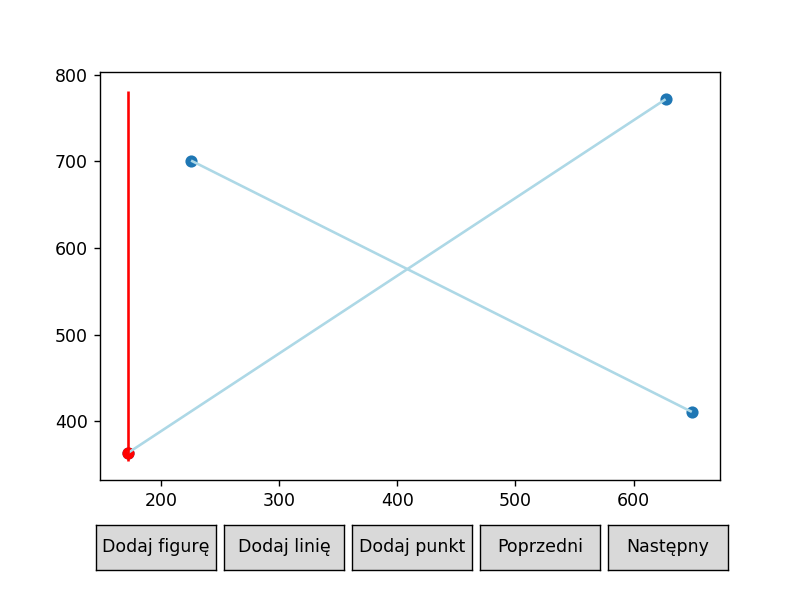

In [32]:
# Krzyż

result = if_intersect(cross)
print(result[0])
plot = Plot(scenes=result[1])
plot.draw()

False


<IPython.core.display.Javascript object>


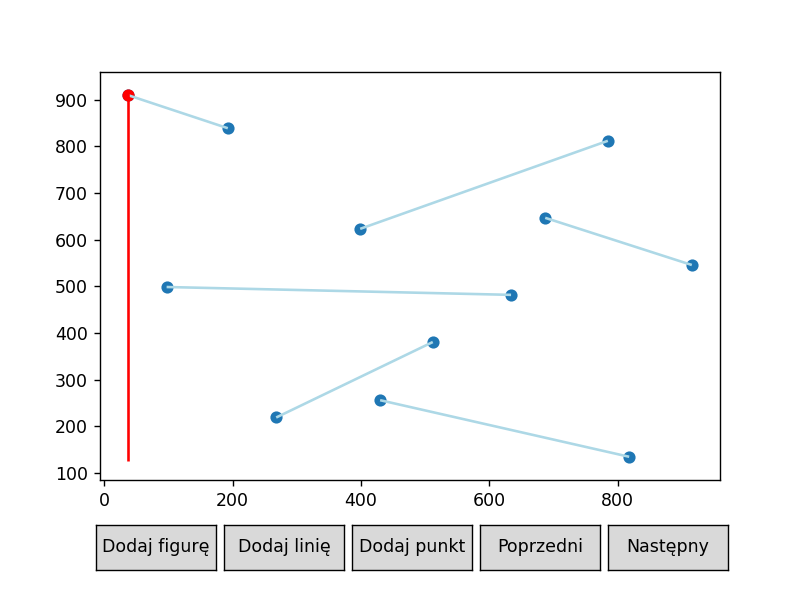

In [33]:
# Nieprzecinające się odcinki

result = if_intersect(nonintersecting)
print(result[0])
plot = Plot(scenes=result[1])
plot.draw()

True


<IPython.core.display.Javascript object>


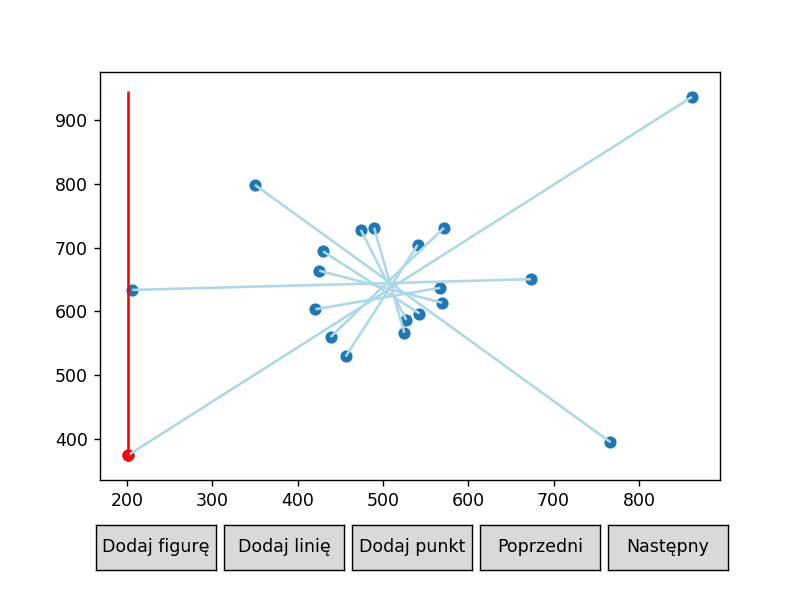

In [34]:
# Gwiazda

result = if_intersect(star)
print(result[0])
plot = Plot(scenes=result[1])
plot.draw()

In [43]:
from queue import PriorityQueue
from sortedcontainers import SortedSet

def all_intersections(pl):
    broom = Broom(0)
    points, lines = plot_to_objects(pl, broom)
    base_lines = plot_to_lines(pl)
    base_points = plot_to_points(pl)
    down_boundary, up_boundary = find_boundaries(points)
    
    Q = PriorityQueue()
    T = SortedSet()
    
    for point in points:
        Q.put(point)

    scenes = []
    processed_points = []
    result = SortedSet()
    full_result = []
    while not Q.empty():
        p = Q.get()
        broom.update(p.x)
        
        broom_visualize = [(p.x, down_boundary), (p.x, up_boundary)]
        current_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
        scenes.append(Scene([PointsCollection(base_points.copy()), 
                             PointsCollection(processed_points.copy(), color = 'lightblue'),
                             PointsCollection([(p.x, p.y)], color='red'),
                            PointsCollection(result.copy(), color = 'springgreen')],
                            [LinesCollection(base_lines, color='lightblue'),
                             LinesCollection(current_lines.copy()),
                             LinesCollection([broom_visualize], color='red')]))
        
        
        if p.typ == 'begin':
            T.add(lines[p.line1])
            i = T.index(lines[p.line1])
            
            if i - 1 >= 0 and find_intersection(T[i - 1], T[i], broom.x) is not None:
                current_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
                scenes.append(Scene([PointsCollection(base_points.copy()), 
                             PointsCollection(processed_points.copy(), color = 'lightblue'),
                             PointsCollection([(p.x, p.y)], color='red'),
                            PointsCollection(result.copy(), color = 'springgreen')],
                            [LinesCollection(base_lines, color='lightblue'),
                             LinesCollection(current_lines.copy()),
                             LinesCollection([((T[i].A.x, T[i].A.y), (T[i].B.x, T[i].B.y)), ((T[i - 1].A.x, T[i - 1].A.y), (T[i - 1].B.x, T[i - 1].B.y))], color='springgreen'),
                            LinesCollection([broom_visualize], color='red')]))
                
                inter = find_intersection(T[i - 1], T[i], broom.x)
                Q.put(Point(inter[0], inter[1], T[i - 1].index, T[i].index, 'intersection'))
                result.add(inter)
                full_result.append((inter, (line_to_list(T[i - 1]), line_to_list(T[i]))))
                
            if i + 1 < len(T) and find_intersection(T[i], T[i + 1], broom.x) is not None:
                current_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
                scenes.append(Scene([PointsCollection(base_points.copy()), 
                             PointsCollection(processed_points.copy(), color = 'lightblue'),
                             PointsCollection([(p.x, p.y)], color='red'),
                            PointsCollection(result.copy(), color = 'springgreen')],
                            [LinesCollection(base_lines, color='lightblue'),
                             LinesCollection(current_lines.copy()),
                             LinesCollection([((T[i].A.x, T[i].A.y), (T[i].B.x, T[i].B.y)), ((T[i + 1].A.x, T[i + 1].A.y), (T[i + 1].B.x, T[i + 1].B.y))], color='springgreen'),
                            LinesCollection([broom_visualize], color='red')]))
                
                inter = find_intersection(T[i], T[i + 1], broom.x)
                Q.put(Point(inter[0], inter[1], T[i].index, T[i + 1].index, 'intersection'))
                result.add(inter)
                full_result.append((inter, (line_to_list(T[i]), line_to_list(T[i + 1]))))
            
        elif p.typ == 'end':
            i = T.index(lines[p.line1])
            if i - 1 >=0 and i + 1 < len(T) and find_intersection(T[i - 1], T[i + 1], broom.x) is not None:
                current_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
                scenes.append(Scene([PointsCollection(base_points.copy()), 
                             PointsCollection(processed_points.copy(), color = 'lightblue'),
                             PointsCollection([(p.x, p.y)], color='red'),
                            PointsCollection(result.copy(), color = 'springgreen')],
                            [LinesCollection(base_lines, color='lightblue'),
                             LinesCollection(current_lines.copy()),
                             LinesCollection([((T[i + 1].A.x, T[i + 1].A.y), (T[i + 1].B.x, T[i + 1].B.y)), ((T[i - 1].A.x, T[i - 1].A.y), (T[i - 1].B.x, T[i - 1].B.y))], color='springgreen'),
                            LinesCollection([broom_visualize], color='red')]))
                
                inter = find_intersection(T[i - 1], T[i + 1], broom.x)
                if result.count(inter) == 0:
                    Q.put(Point(inter[0], inter[1], T[i - 1].index, T[i + 1].index, 'intersection'))
                    result.add(inter)
                    full_result.append((inter, (line_to_list(T[i - 1]), line_to_list(T[i + 1]))))
            
            T.remove(lines[p.line1])
            
        else:
            l1 = lines[p.line1]
            l2 = lines[p.line2]
            
            
            broom.update(p.x - 0.000001)
            T.remove(l1)
            T.remove(l2)
            broom.update(p.x)
            
            T.add(l1)
            T.add(l2)
            
            
            i1 = T.index(l1)
            i2 = T.index(l2)
            
            if i1 > i2:
                i1, i2 = i2, i1
            
            if i1 - 1 >= 0 and find_intersection(T[i1 - 1], T[i1], broom.x) is not None:
                current_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
                scenes.append(Scene([PointsCollection(base_points.copy()), 
                             PointsCollection(processed_points.copy(), color = 'lightblue'),
                             PointsCollection([(p.x, p.y)], color='red'),
                            PointsCollection(result.copy(), color = 'springgreen')],
                            [LinesCollection(base_lines, color='lightblue'),
                             LinesCollection(current_lines.copy()),
                             LinesCollection([((T[i1].A.x, T[i1].A.y), (T[i1].B.x, T[i1].B.y)), ((T[i1 - 1].A.x, T[i1 - 1].A.y), (T[i1 - 1].B.x, T[i1 - 1].B.y))], color='springgreen'),
                            LinesCollection([broom_visualize], color='red')]))
                
                inter = find_intersection(T[i1 - 1], T[i1], broom.x)
                if result.count(inter) == 0:
                    Q.put(Point(inter[0], inter[1], T[i1 - 1].index, T[i1].index, 'intersection'))
                    result.add(inter)
                    full_result.append((inter, (line_to_list(T[i1 - 1]), line_to_list(T[i1]))))
                    
            if i2 + 1 < len(T) and find_intersection(T[i2], T[i2 + 1], broom.x) is not None:
                current_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
                scenes.append(Scene([PointsCollection(base_points.copy()), 
                             PointsCollection(processed_points.copy(), color = 'lightblue'),
                             PointsCollection([(p.x, p.y)], color='red'),
                            PointsCollection(result.copy(), color = 'springgreen')],
                            [LinesCollection(base_lines, color='lightblue'),
                             LinesCollection(current_lines.copy()),
                             LinesCollection([((T[i2].A.x, T[i2].A.y), (T[i2].B.x, T[i2].B.y)), ((T[i2 + 1].A.x, T[i2 + 1].A.y), (T[i2 + 1].B.x, T[i2 + 1].B.y))], color='springgreen'),
                            LinesCollection([broom_visualize], color='red')]))
                
                inter = find_intersection(T[i2], T[i2 + 1], broom.x)
                if result.count(inter) == 0:
                    Q.put(Point(inter[0], inter[1], T[i2].index, T[i2 + 1].index, 'intersection'))
                    result.add(inter)
                    full_result.append((inter, (line_to_list(T[i2 - 1]), line_to_list(T[i2]))))
                             
        processed_points.append((p.x, p.y))
                             
    return result, full_result, scenes

Intersecting point:  (408.5296863091577, 575.7233394707106)
Intersecting lines:  ([(172.35631019838397, 363.89016544117646), (626.9934069725775, 771.6720281862745)], [(225.58211664999683, 700.8999693627452), (649.1708263274162, 411.071537990196)])


ilosc przeciec:  1


<IPython.core.display.Javascript object>


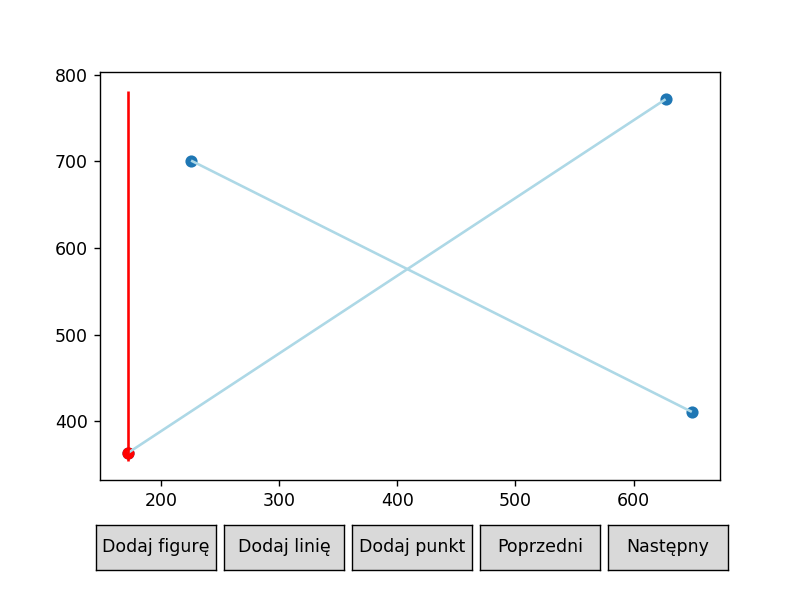

In [44]:
# Krzyż

result = all_intersections(cross)

for i in range(len(result[1])):
    intersection = result[1][i]
    print('Intersecting point: ', intersection[0])
    print('Intersecting lines: ', intersection[1])
    print('\n')
print('ilosc przeciec: ', len(result[0]))
    
plot = Plot(scenes=result[2])
plot.draw()

ilosc przeciec:  0


<IPython.core.display.Javascript object>


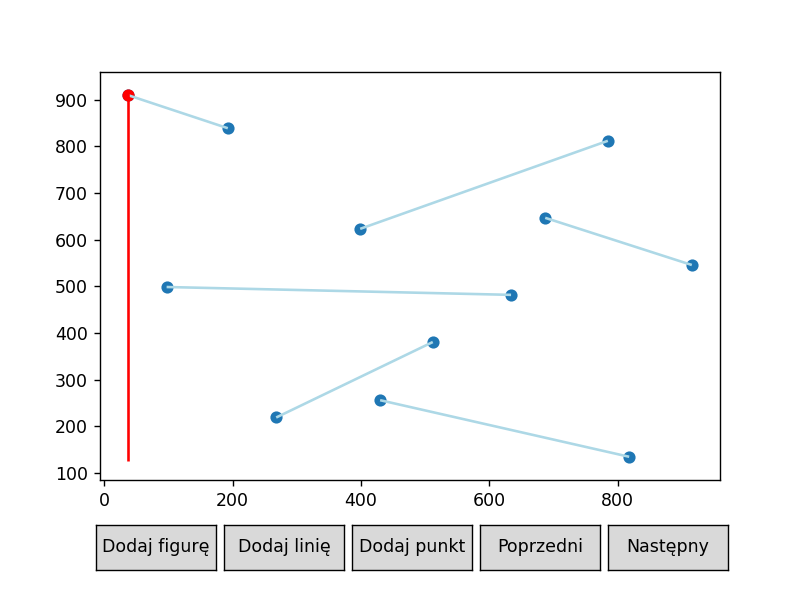

In [45]:
# Nieprzecinające się odcinki

result = all_intersections(nonintersecting)

for i in range(len(result[1])):
    intersection = result[1][i]
    print('Intersecting point: ', intersection[0])
    print('Intersecting lines: ', intersection[1])
    print('\n')
print('ilosc przeciec: ', len(result[0]))

plot = Plot(scenes=result[2])
plot.draw()

Intersecting point:  (543.1080987562152, 473.09309562579483)
Intersecting lines:  ([(76.9934069725775, 108.43674949571192), (899.7756650370937, 752.1254749859081)], [(12.678890843545247, 897.0396906721826), (995.1385682629001, 111.80684753492756)])


Intersecting point:  (645.5764617185574, 391.19505356885253)
Intersecting lines:  ([(613.6869553596742, 162.35831812316292), (693.5256650370936, 735.2749847898297)], [(12.678890843545247, 897.0396906721826), (995.1385682629001, 111.80684753492756)])


Intersecting point:  (670.9240671165257, 573.0875923042737)
Intersecting lines:  ([(12.678890843545247, 897.0396906721826), (995.1385682629001, 111.80684753492756)], [(613.6869553596742, 162.35831812316292), (693.5256650370936, 735.2749847898297)])


Intersecting point:  (768.8624003255852, 292.6585229444822)
Intersecting lines:  ([(755.622439230642, 118.54704361335894), (813.2837295532228, 876.8191024368884)], [(12.678890843545247, 897.0396906721826), (995.1385682629001, 111.80684753492756)]

<IPython.core.display.Javascript object>


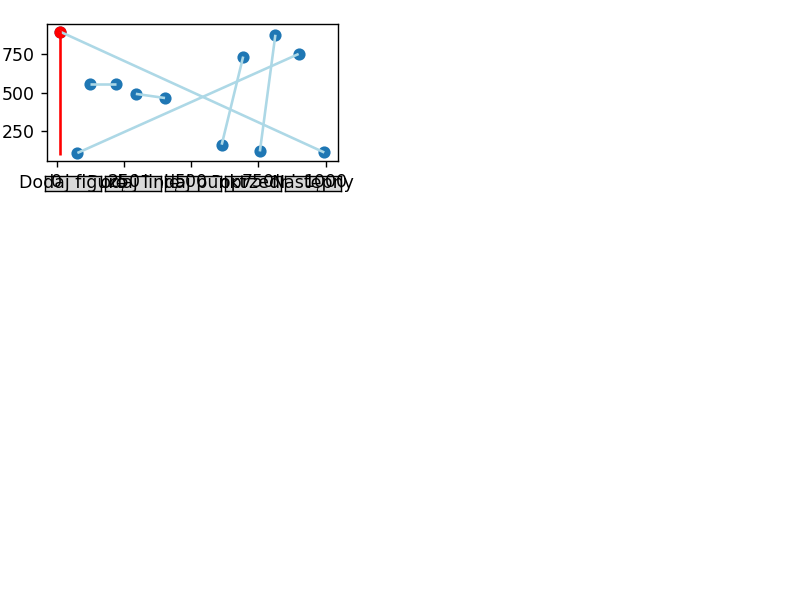

In [46]:
# Przyklad z cwiczen

result = all_intersections(example)

for i in range(len(result[1])):
    intersection = result[1][i]
    print('Intersecting point: ', intersection[0])
    print('Intersecting lines: ', intersection[1])
    print('\n')
print('ilosc przeciec: ', len(result[0]))

plot = Plot(scenes=result[2])
plot.draw()

ilosc przeciec:  19


<IPython.core.display.Javascript object>


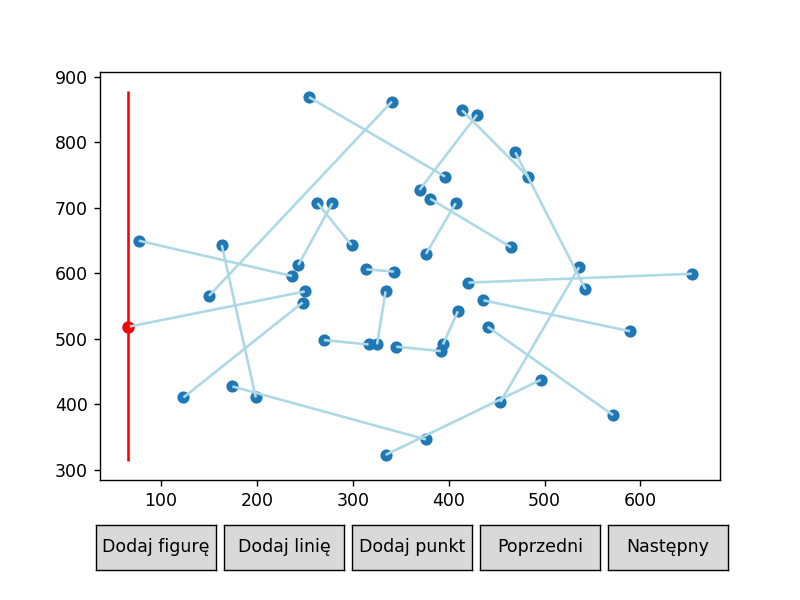

In [47]:
# Kot

result = all_intersections(cat)
print('ilosc przeciec: ', len(result[0]))
plot = Plot(scenes=result[2])
plot.draw()

ilosc przeciec:  43


<IPython.core.display.Javascript object>


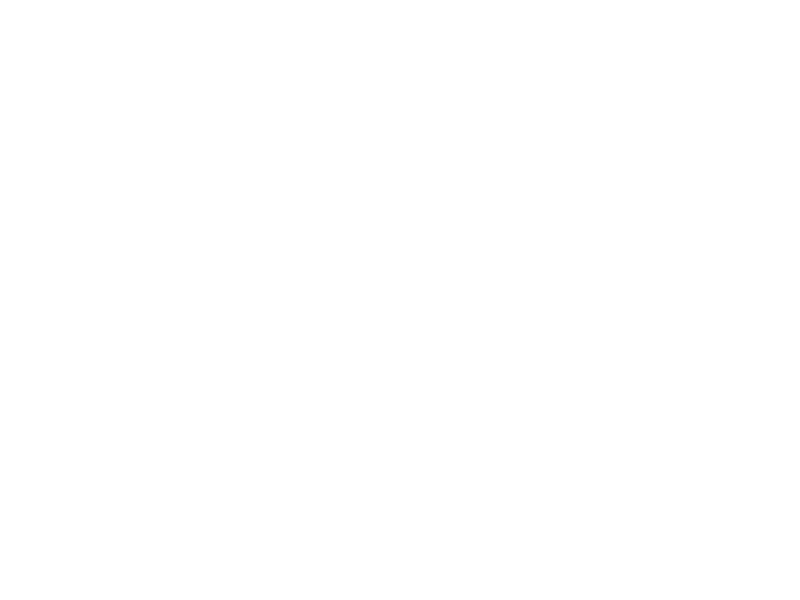

In [49]:
# Star

result = all_intersections(star)
print('ilosc przeciec: ', len(result[0]))
plot = Plot(scenes=result[2])
plot.draw()

ilosc przeciec:  12


<IPython.core.display.Javascript object>


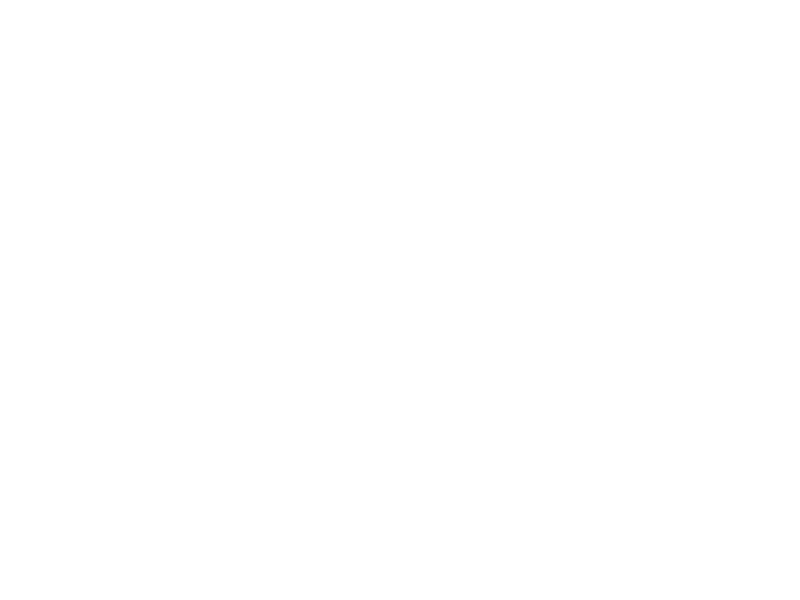

In [50]:
# Ladder

result = all_intersections(ladder)
print('ilosc przeciec: ', len(result[0]))
plot = Plot(scenes=result[2])
plot.draw()

ilosc przeciec:  1197


<IPython.core.display.Javascript object>


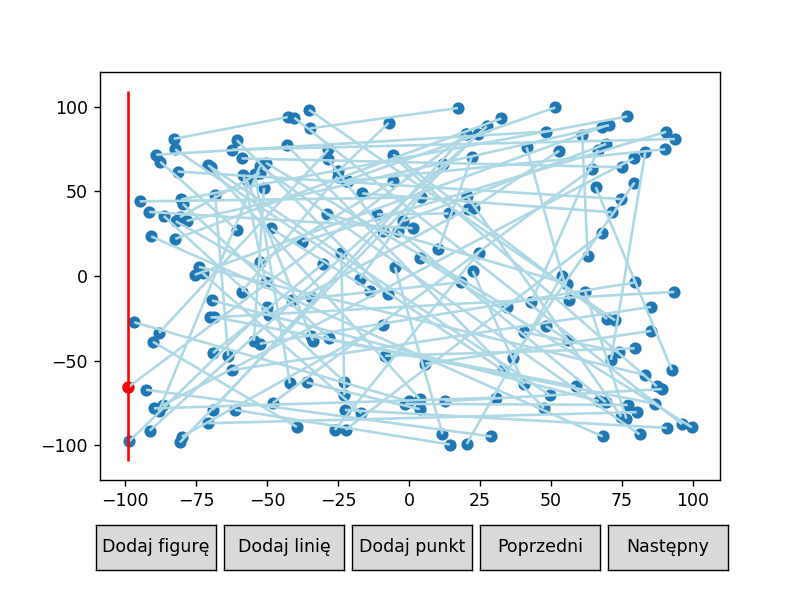

In [52]:
# Losowe linie

result = all_intersections(rand_lines)
print('ilosc przeciec: ', len(result[0]))
plot = Plot(scenes=result[2])
plot.draw()